In [2]:
import warnings
warnings.filterwarnings('ignore')

In [123]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor



In [4]:
%matplotlib inline

In [5]:
def load_housing_data():
    return pd.read_csv(os.path.join("dataset", "housing.csv"))

In [6]:
housing = load_housing_data()

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
# random splitting
# Prone to sampling bias
random_train_set, random_test_set = train_test_split(housing, test_size=0.2, random_state=42)

Since random splitting of datasets to test and train sets is prone to dangerous sampling biases, We go for a better alternative 

**Stratified Sampling Method**.

1. Always choose the most important attribute for Stratified Sampling.
2. Should be performed on catagorical attributes.
3. If the most important attribute is a continous numeric attribute, <br /> then create a new catagorical feature of the attribute and perform *SSM* on that.
4. Since SSM is based on dividing the whole dataset to homogenous subgroups called strata, we should keep in mind that


    * Each stratum sould be large enough.
    * Try to reduce the number of strata.

<AxesSubplot:>

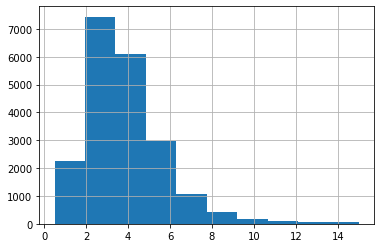

In [9]:
housing['median_income'].hist()

In [10]:
np.ceil(housing['median_income']/1.5).value_counts()

3.0     7236
2.0     6581
4.0     3639
5.0     1423
1.0      822
6.0      532
7.0      189
8.0      105
9.0       50
11.0      49
10.0      14
Name: median_income, dtype: int64

In [11]:
housing['income_cat'] = np.ceil(housing['median_income']/1.5)

In [12]:
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

# .where() meaning 
# where(pass when housing['income_cat'] is lt 5, when not pass, replace with 5.0, modify the original Series)

In [13]:
housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

<AxesSubplot:>

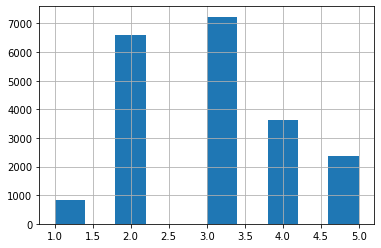

In [14]:
housing['income_cat'].hist()

In [15]:
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in stratified_splitter.split(housing, housing['income_cat']):
    train_set = housing.loc[train_index]
    test_set = housing.loc[test_index]

In [16]:
train_set['income_cat'].value_counts() / len(train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [17]:
test_set['income_cat'].value_counts() / len(test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [18]:
# Removing income_cat attribute from test and train sets
for set_ in (train_set, test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [19]:
housing = train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

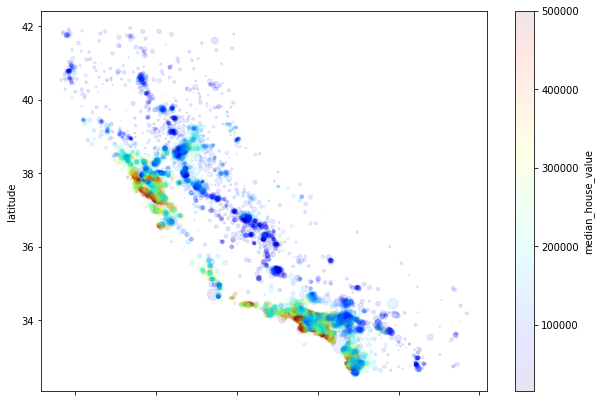

In [20]:
housing.plot(kind="scatter", x='longitude', y="latitude", alpha=0.1, figsize=(10, 7), c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True, s=housing['population']/100)

In [21]:
housing.corr()['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='latitude', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>,
        <AxesSubplot:xlabel='latitude', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='to

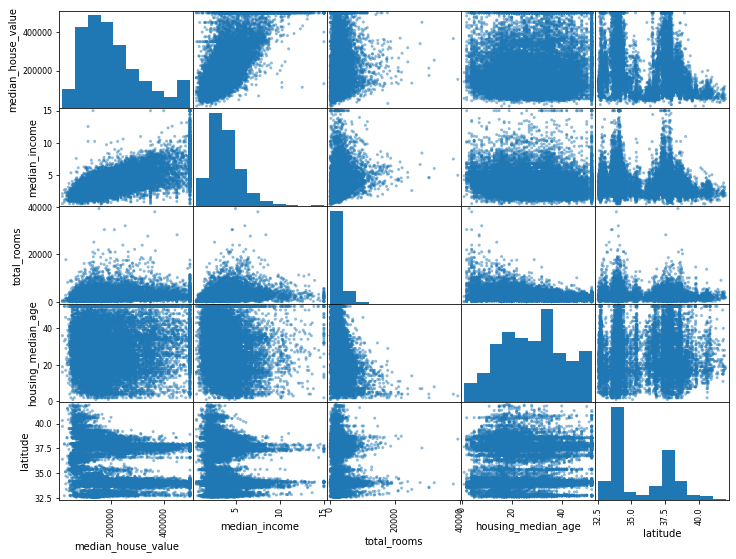

In [22]:
attributes = [
    'median_house_value',
    'median_income',
    'total_rooms',
    'housing_median_age',
    'latitude'
]

scatter_matrix(housing[attributes], figsize=(12, 9))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

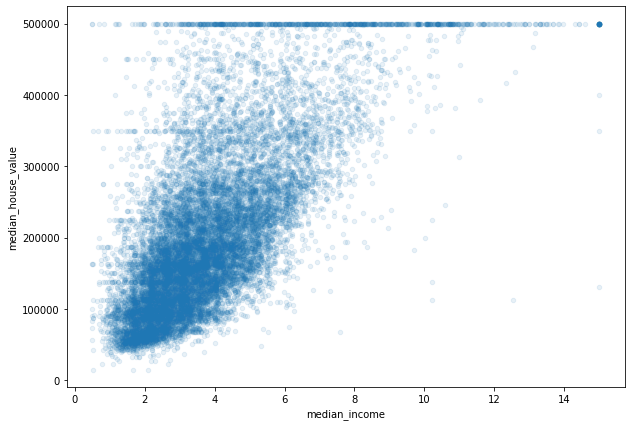

In [23]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, figsize=(10, 7))

In [24]:
housing['rooms_per_households'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_rooms'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [25]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'rooms_per_households',
       'bedrooms_per_rooms', 'population_per_household'],
      dtype='object')

In [26]:
housing.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_households        0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_rooms         -0.259984
Name: median_house_value, dtype: float64

In [27]:
housing = train_set.drop('median_house_value', axis=1)
housing_labels = train_set['median_house_value'].copy()

# Data Cleaning

### Handling Missing attributes


Can be done by:

1. Removing the whole column
        Eg:- housing.drop['total_bedrooms', axis=1]

2. Removing instances with missing attributes
        Eg:- housing.dropna(subset=['total_bedrooms'])
        
3. Filling missing attributres with zero, mean, median or something
        Eg:- 
        median = housing['total_bedrooms'].median()
        housing['total_bedrooms'].fillna(median, inplace=True)

In [28]:
imputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [29]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [30]:
x = imputer.transform(housing_num)
housing_tr = pd.DataFrame(x, columns=housing_num.columns)

In [31]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
...,...,...,...,...,...,...,...,...
16507,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312
16508,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682
16509,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723
16510,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625


In [32]:
print(imputer.strategy)
print(imputer.statistics_)

median
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


In [33]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.0 MB


In [34]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


### Categorical Text Handling using Encoding Techniques

In [35]:
encoder = LabelEncoder()

In [36]:
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [37]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

In [38]:
encoder = OneHotEncoder()

In [39]:
housing_cat_onehot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))

In [40]:
housing_cat_onehot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [41]:
encoder = LabelBinarizer()

In [42]:
housing_cat_labelbin = encoder.fit_transform(housing_cat)

In [43]:
housing_cat_labelbin

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [44]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombineAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_rooms=True):
        self.add_bedrooms_per_rooms = add_bedrooms_per_rooms
    
    def fit(self, dataset):
        return self
    
    def transform(self, dataset):
        rooms_per_households = dataset[:, rooms_ix] / dataset[:, households_ix] 
        households_per_population = dataset[:, households_ix]  / dataset[:, population_ix] 
        if self.add_bedrooms_per_rooms:
            bedrooms_per_rooms = dataset[:, bedrooms_ix]  / dataset[:, rooms_ix]
            return np.c_[dataset, rooms_per_households, households_per_population, bedrooms_per_rooms]
        else:
            return np.c_[dataset, rooms_per_households, households_per_population]
        



In [45]:
attributes_combiner = CombineAttributes(add_bedrooms_per_rooms=True)

In [46]:
attributes_combiner.fit(housing)

CombineAttributes()

In [47]:
housing = attributes_combiner.transform(housing.values)

In [48]:
housing

array([[-121.89, 37.29, 38.0, ..., 4.625368731563422,
        0.47746478873239434, 0.22385204081632654],
       [-121.93, 37.05, 14.0, ..., 6.008849557522124, 0.369281045751634,
        0.15905743740795286],
       [-117.2, 32.77, 31.0, ..., 4.225108225108225, 0.4935897435897436,
        0.24129098360655737],
       ...,
       [-116.4, 34.09, 9.0, ..., 6.34640522875817, 0.3646329837940896,
        0.1796086508753862],
       [-118.01, 33.82, 31.0, ..., 5.50561797752809, 0.26253687315634217,
        0.19387755102040816],
       [-122.45, 37.77, 52.0, ..., 4.843505477308295, 0.5035460992907801,
        0.22035541195476574]], dtype=object)

In [49]:
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625


In [50]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('combine_attr', CombineAttributes()),
    ('std_scaler', StandardScaler())
])

In [51]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [52]:
pd.DataFrame(housing_num_tr).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       16512 non-null  float64
 1   1       16512 non-null  float64
 2   2       16512 non-null  float64
 3   3       16512 non-null  float64
 4   4       16512 non-null  float64
 5   5       16512 non-null  float64
 6   6       16512 non-null  float64
 7   7       16512 non-null  float64
 8   8       16512 non-null  float64
 9   9       16512 non-null  float64
 10  10      16512 non-null  float64
dtypes: float64(11)
memory usage: 1.4 MB


In [53]:
housing = train_set

In [54]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, selected_attributes=[]):
        print(selected_attributes)
        self.selected_attributes = selected_attributes
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return X[self.selected_attributes].values

    
class MyLabelBinarizer(TransformerMixin):
    def __init__(self):
        self.binarizer = LabelBinarizer()
    
    def fit(self, X, y=None):
        self.binarizer.fit(X)
        return self
    
    def transform(self, X, y=None):
        return self.binarizer.transform(X)

In [55]:
num_attr_list = list(housing_num.columns)

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(selected_attributes=num_attr_list)),
    ('imputer', SimpleImputer(strategy='median')),
    ('attr_adder', CombineAttributes()),
    ('std_scaler', StandardScaler())
])

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


In [56]:
cat_attr_list = ['ocean_proximity']
categories_list = list(housing['ocean_proximity'].unique().reshape(1, -1))

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(selected_attributes=cat_attr_list)),
#     ('binarizer', MyLabelBinarizer()),
    ('encoder', OneHotEncoder(categories=categories_list, sparse=False))
])

['ocean_proximity']


In [57]:
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [58]:
housing_prepared = full_pipeline.fit_transform(housing)

In [59]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

### Training using Algorithms

In [78]:
# Using Linear Regression

lin_reg = LinearRegression()

In [61]:
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [62]:
some_data = housing.iloc[:5]

In [63]:
some_labels = housing_labels[:5]

In [64]:
some_data_prepared = full_pipeline.transform(some_data)

In [65]:
lin_reg.predict(some_data_prepared)

array([235584., 322688., 231936.,  43712., 190720.])

In [67]:
housing_predictions = lin_reg.predict(housing_prepared)

In [77]:
# Calculating root mean squared error

lin_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))

In [82]:
# Using Decision Tree Regression

tree_reg = DecisionTreeRegressor()

In [83]:
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [84]:
tree_predicted = tree_reg.predict(housing_prepared)

In [85]:
tree_rmse = np.sqrt(mean_squared_error(tree_predicted, housing_labels))

In [86]:
tree_rmse

0.0

#### Cross validaion (K - Fold)

In [90]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)

In [91]:
scores

array([-4.88263345e+09, -4.35948940e+09, -4.97581633e+09, -4.89996624e+09,
       -4.95140872e+09, -5.64927226e+09, -5.18298923e+09, -5.00183732e+09,
       -5.77185627e+09, -4.82814313e+09])

In [93]:
cross_tree_scores = np.sqrt(-scores)

In [94]:
cross_tree_scores

array([69875.84310531, 66026.42958451, 70539.46645387, 69999.75883692,
       70366.2470565 , 75161.64087108, 71992.98045593, 70723.66876689,
       75972.73370857, 69484.84100012])

In [96]:
print(cross_tree_scores.mean())
cross_tree_scores.std()

71014.36098397037


2702.1786868239456

In [97]:
lin_cross_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)

In [100]:
lin_cross_scores = np.sqrt(-lin_cross_scores)

In [101]:
print(lin_cross_scores.mean())
lin_cross_scores.std()

66079.6056659299


1891.0399461369432

In [107]:
forest_reg = RandomForestRegressor()

In [108]:
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [110]:
forest_predicted = forest_reg.predict(housing_prepared)

In [115]:
forest_score = np.sqrt(mean_squared_error(forest_predicted, housing_labels))

In [116]:
forest_score

18689.59650879125

In [111]:
forest_cross_score = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)

In [113]:
forest_cross_score = np.sqrt(-forest_cross_score)
forest_cross_score

array([49470.46297557, 47804.95513601, 49810.24630127, 52405.31500704,
       49621.60944275, 53384.11541485, 48558.65422945, 47902.0840706 ,
       53187.89143887, 50031.99774892])

In [114]:
print(forest_cross_score.mean()forest_cross_scorecross_score.std()

50217.73317653339


1966.8228673861536

### Saving Model using joblib


Please note that joblib is no more available in sklearn as **sklearn.externals.joblib**

should be imported as

```import joblib```

In [119]:
joblib.dump(forest_reg, 'forest_reg.pkl')

['forest_reg.pkl']

In [121]:
forest_reg = joblib.load('forest_reg.pkl')

### Fine tuning 

In [124]:
params_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

In [125]:
forest_reg = RandomForestRegressor()

In [127]:
grid_search = GridSearchCV(forest_reg, params_grid, cv=5, scoring='neg_mean_squared_error')

In [128]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [129]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [132]:
grid_seach_cv_res = grid_search.cv_results_

In [136]:
for rank, mean_test_score, params in zip(grid_seach_cv_res['rank_test_score'], grid_seach_cv_res['mean_test_score'], grid_seach_cv_res['params']):
    print('rank: ', rank, '\n')
    print('mean test score: ', np.sqrt(-mean_test_score), '\n')
    print('params: ', params, '\n\n')

rank:  18 

mean test score:  64249.00058041014 

params:  {'max_features': 2, 'n_estimators': 3} 


rank:  11 

mean test score:  55666.87345216264 

params:  {'max_features': 2, 'n_estimators': 10} 


rank:  9 

mean test score:  52811.98309058902 

params:  {'max_features': 2, 'n_estimators': 30} 


rank:  15 

mean test score:  59443.9641276998 

params:  {'max_features': 4, 'n_estimators': 3} 


rank:  8 

mean test score:  52718.00331366208 

params:  {'max_features': 4, 'n_estimators': 10} 


rank:  3 

mean test score:  50533.12955063045 

params:  {'max_features': 4, 'n_estimators': 30} 


rank:  14 

mean test score:  59048.19205860203 

params:  {'max_features': 6, 'n_estimators': 3} 


rank:  6 

mean test score:  52111.061632735014 

params:  {'max_features': 6, 'n_estimators': 10} 


rank:  1 

mean test score:  49856.424782474336 

params:  {'max_features': 6, 'n_estimators': 30} 


rank:  13 

mean test score:  58653.36912331079 

params:  {'max_features': 8, 'n_estimat

In [137]:
best_forest_reg = grid_search.best_estimator_

In [138]:
best_forest_reg

RandomForestRegressor(max_features=6, n_estimators=30)

> Apart from GridSearchCV, there exists sklearn.model_selection.RandomizedSearchCV<Br />
> Works by setting the number of iterations

### Testing using Test Set

In [140]:
X_test  = test_set.drop('median_house_value', axis=1)

In [141]:
Y_test = test_set['median_house_value'].copy()

In [142]:
test_set_prepared = full_pipeline.transform(X_test)

In [143]:
test_set_predictions = best_forest_reg.predict(test_set_prepared)

In [147]:
test_set_score = mean_squared_error(Y_test, test_set_predictions)

In [149]:
test_set_score = np.sqrt(test_set_score)

In [150]:
test_set_score

47685.72787716265